In [13]:
%matplotlib inline

import functools
import os
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook
tqdm.pandas("Progress: ")

import numpy as np
import matplotlib
import pandas as pd
import pybedtools
import pysam
import seaborn as sns
import matplotlib
from matplotlib import gridspec
import scipy
from gscripts import qtools
from Bio import SeqIO
from gscripts.general import dataviz
from IPython.core.display import HTML
from matplotlib import pyplot as plt

img_dir = "/home/gpratt/Dropbox/EricGabe_ENCODE/papers/peaks_outside_genes"

sns.set_style("ticks")

RESET = False

In [46]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [ ]:
sort -i /home/gpratt/clipper/clipper/data/hg19.AS.STRUCTURE.COMPILED.gff > ~/projects/encode/analysis/ad-hoc/hg19.AS.STRUCTURE.COMPILED.sorted.gff
merge -i ~/projects/encode/analysis/ad-hoc/hg19.AS.STRUCTURE.COMPILED.sorted.gff > ~/projects/encode/analysis/ad-hoc/hg19.AS.STRUCTURE.COMPILED.sorted.merged.gff


In [ ]:
bedtools makewindows -b hg19.AS.STRUCTURE.COMPILED.gff -w 100 > ~/projects/encode/analysis/ad-hoc/windows.bed

In [8]:
input_norm_dir = "/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_CLIPperv2_20170130"
split_dir = "/home/gpratt/projects/idr/analysis/idr_v1/"
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"
downsample_path = "/home/gpratt/projects/idr/analysis/downsample_v2/"

In [ ]:
 intersectBed -a ~/projects/encode/analysis/ad-hoc/windows.bed -b /home/gpratt/projects/encode/analysis/peak_reanalysis_v14/*_3_pval_3.clipper.bed -wo -filenames

In [14]:
def get_gps_peak(fn):
    gps_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    fn = os.path.basename(fn)
    basename = fn.split(".")[0]
    
    fn = os.path.join(gps_dir, "{}/{}_outputs/{}_2_GEM_events.bed".format(basename, basename, basename))
    return fn

def make_and_filter_clipper(fn, l2fc, pval):
    bedtool = pybedtools.BedTool(fn)
    
    filter_data_inst = functools.partial(filter_data, l2fc=l2fc, pval=pval)
    out_file = os.path.join(out_dir, os.path.basename(bedtool.fn) + "l2fc_{}_pval_{}.clipper.bed".format(l2fc, pval))
    if not os.path.exists(out_file):
        bedtool = bedtool.filter(filter_data_inst).saveas(out_file)

    return out_file

def make_clipper_ish(interval):
    interval.name = interval[7]
    interval[6] = interval.start
    interval[7] = interval.stop
    return interval

def filter_data(interval, l2fc, pval):
    #col4 is -log10 p-val
    #col5 is -log2 fold enrichment

    #This is the standard one 
    return (float(interval[3]) >= pval) and (float(interval[4]) >= l2fc)

def format_frip_analysis(bam_file, bed_file, out_file=None):
    path, ext = os.path.splitext(os.path.basename(bed_file))
    if not out_file:
        metrics = path + ".metrics"
    else:
        metrics = out_file
        
    return "python /home/gpratt/gscripts/gscripts/clipseq/calculate_frip.py --bed {} --bam {} --out_file {}".format(bed_file, bam_file, metrics)

def sort_and_return_peaks(fn, force=False):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    out_fn = os.path.join(out_dir, os.path.basename(fn))
    if os.path.exists(out_fn) and not RESET:
        return out_fn
    
    bedtool = pybedtools.BedTool(fn)
    bedtool = pybedtools.BedTool([pybedtools.create_interval_from_list(str(interval).split()) for interval in bedtool])

    
    bedtool = bedtool.sort().saveas(out_fn)
    return bedtool.fn

def sort_bed(fn):
    out_file = os.path.splitext(fn)[0] + ".sorted.bed"
    
    if os.path.exists(out_file) and not RESET:
        return out_file
    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.sort().saveas(out_file)
    return bedtool.fn

In [4]:
make_and_filter_clipper_stringent = functools.partial(make_and_filter_clipper, l2fc=5, pval=3)
make_and_filter_clipper_very_lineant = functools.partial(make_and_filter_clipper, l2fc=0, pval=1)
make_and_filter_clipper_lineant = functools.partial(make_and_filter_clipper, l2fc=2, pval=1.3)
make_and_filter_clipper_moderate = functools.partial(make_and_filter_clipper, l2fc=3, pval=3)

In [5]:
#Converts reps into dataframe, like they should be
submitted_datasets = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_CLIPperv2_20170130/ALLDATASETS_submittedonly.txt")
submitted_datasets = submitted_datasets.set_index(["uID", "RBP", "Cell line", "INPUT"])
submitted_datasets.columns = pd.MultiIndex.from_tuples([item.split("_") for item in submitted_datasets.columns])
submitted_datasets = submitted_datasets.stack()
submitted_datasets['INPUT'] = submitted_datasets.index.get_level_values(level="INPUT")
submitted_datasets.index = submitted_datasets.index.droplevel("INPUT")

In [6]:
def format_input_norm(row):
    uID = row.name[0]
    rep = row.name[-1]
    if rep == "rep1":
        rep_num = "01"
    elif rep == "rep2":
        rep_num = "02"
    else:
        print "error"
    #The one shitty part of this new approach is being careful how I deal with the input norm datasets
    return os.path.join(input_norm_dir, "{0}_{1}.basedon_{0}_{1}.peaks.l2inputnormnew.bed.compressed.bed.annotated".format(uID, rep_num))

In [9]:
#Format Data
submitted_datasets['gps'] = submitted_datasets.CLIP.progress_apply(get_gps_peak)
submitted_datasets['input_norm'] = submitted_datasets.progress_apply(format_input_norm, axis=1)
submitted_datasets = submitted_datasets[submitted_datasets['input_norm'].apply(os.path.exists)]
submitted_datasets['filtered_moderate'] = submitted_datasets['input_norm'].progress_apply(make_and_filter_clipper_moderate)



  0%|          | 0/3 [00:00<?, ?it/s]
362it [00:00, 4096.04it/s]           
100%|██████████| 362/362 [00:00<00:00, 562.76it/s]

In [15]:
submitted_datasets['filtered_moderate_sorted'] = submitted_datasets.filtered_moderate.progress_apply(sort_bed)

In [17]:
submitted_datasets['filtered_moderate_sorted'][0]

'/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/203_01.basedon_203_01.peaks.l2inputnormnew.bed.compressed.bed.annotatedl2fc_3_pval_3.clipper.sorted.bed'

In [18]:
intersectBed -a ~/projects/encode/analysis/ad-hoc/windows.sorted.bed -b /home/gpratt/projects/encode/analysis/peak_reanalysis_v14/*_3_pval_3.clipper.sorted.bed -wo -filenames -sorted > ~/projects/encode/analysis/ad-hoc/interesected.bed

In [47]:
names = ["chrom", "start", "stop", "fn", "chrom_peak", 
         "start_peak", "stop_peak", "name_peak", "score_peak", 
         "strand_peak", "annotation_peak", "gene_peak", "overlap_peak"]

In [59]:
df = pd.read_table("/home/gpratt/projects/encode/analysis/ad-hoc/interesected_smaller.bed", header=None, names=names)

In [60]:
grouped = df.groupby(["chrom", "start", "stop"])

In [75]:
foo = grouped['fn'].agg(lambda x: len(set(x)))

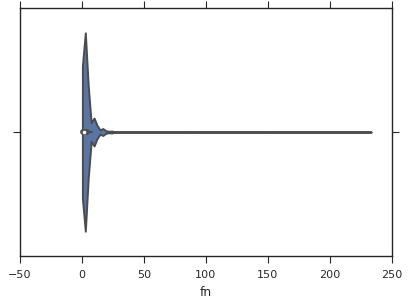

In [62]:
sns.violinplot(foo)

In [ ]:
Filtering Criteria
Potentally filter out SLBP
Use motif analysis on these highly repetitive regions

In [76]:
foo = foo[foo > 30]

This is the list of potentally blacklisted regions, sorted from most peaks with shit to least

In [77]:
pd.DataFrame(foo).to_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/potental_blacklist_sites.csv")

In [ ]:
blacklist_regions = []

chr6   31958186   31958286
chr15  96826097   96826197 

In [64]:
foo.sort_values(ascending=False)

chrom  start      stop     
chr6   31958186   31958286     233
chr15  96826097   96826197     173
chr17  18965324   18965424     151
       18965424   18965524     151
chr19  893483     893583       143
chr6   10887791   10887891     138
chr19  893583     893590       136
chr14  102706574  102706674    129
       102706674  102706774    129
chr2   230045641  230045741    119
chr10  72577316   72577416     117
chr19  2270251    2270351      117
       2270151    2270251      115
chr3   160122322  160122422    110
chr22  20111054   20111154     105
chr11  32165294   32165394     102
chr6   86352613   86352713     101
chr1   91853022   91853122      99
chr2   230045541  230045641     99
chr1   245026523  245026623     97
chr16  89555737   89555837      96
chrX   117415421  117415521     95
chr7   5569981    5570081       95
chr6   86352713   86352813      93
chrM   9965       10065         92
chr22  20110954   20111054      92
chr13  92000273   92000373      91
chr19  18548173   18548273 